In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

Text(0, 0.5, 'y')

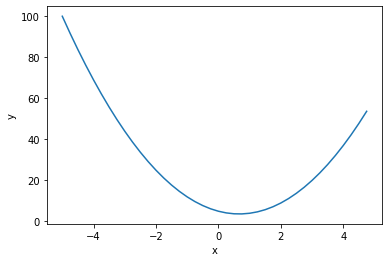

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.xlabel(xlabel='x')
plt.ylabel(ylabel='y')

In [4]:
# Let's try to get the derivative numerically (at x = 3)
h = 0.01
x = 3
(f(x + h) - f(x)) / h
for i in range(20):
    h = h * 0.1
    print((f(x + h) - f(x)) / h)
# At some point, the answer is incorrect, because of floating point arithmetic 
# and the memory for the representation of these numbers is finite.

14.00300000000243
14.000300000063248
14.00003000000538
14.000003002223592
14.000000305713908
14.000000092551085
14.000001158365187
14.000001158365187
14.000178794049125
14.001244608152765
13.997691894473965
14.210854715201993
10.658141036401494
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [5]:
# at x = 2/3
h = 0.0000001
x = 2/3
(f(x + h) - f(x)) / h
# the derivative approaches 0, so at x = 2/3 there is no response by the function to a change in x.

2.9753977059954195e-07

In [6]:
# defining the skeleton of the autograd engine
class Value:
    def __init__(self, data) -> None:
        self.data = data
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"

a = Value(2.0)
b = Value(-3.0)
# a, b are Value objects, we need to define addition for these Value objects.
a + b

TypeError: unsupported operand type(s) for +: 'Value' and 'Value'

In [7]:
# defining the skeleton of the autograd engine
class Value:
    def __init__(self, data) -> None:
        self.data = data
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(a.data + other.data)

# Now addition should work.
a = Value(2.0)
b = Value(-3.0)
a + b

Value(data=-1.0)

Now, let's add some more functionality to cover the basic arithmetical operations.

In [8]:
# defining the skeleton of the autograd engine
class Value:
    def __init__(self, data) -> None:
        self.data = data
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data)
    
    def __mul__(self, other):
        return Value(self.data * other.data)

# Now addition should work.
a = Value(2.0)
b = Value(-3.0)
a + b
a * b


Value(data=-6.0)

Now, we need to create the connected tissue that allows us to know what values were used to create other values.

In [9]:
# defining the skeleton of the autograd engine
class Value:
    def __init__(self, data, children=()) -> None:
        self.data = data
        self._prev = set(children)
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, children=(self, other))
    
    def __mul__(self, other):
        return Value(self.data * other.data, children=(self, other))

# Now addition should work.
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c
print(d, "children = ", d._prev)

Value(data=4.0) children =  {Value(data=-6.0), Value(data=10.0)}


We still don't have a way of tracking what operation was used to create a Value object, so 
let's do that. 

In [10]:
# defining the skeleton of the autograd engine
class Value:
    def __init__(self, data, children=(), op="", label='') -> None:
        self.data = data
        self._prev = set(children)
        self._op = op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, children=(self, other), op='+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, children=(self, other), op='*')

# Now addition should work.
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label = 'c')
d = a*b; d.label = 'd'
e = d + c; e.label = 'e'
f = Value(-2.0, label='f')
L = e*f; L.label = 'L'
print(d, "chilren =", d._prev, "_op =", d._op)

Value(data=-6.0) chilren = {Value(data=2.0), Value(data=-3.0)} _op = *


Now, let's create a way to visualize the graph of interconnected Value objects and their relationships
with respect to each other.

In [11]:
from graphviz import Digraph

def trace(root):
    # keep track of the nodes and edges to form a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

trace(d)

({Value(data=-3.0), Value(data=-6.0), Value(data=2.0)},
 {(Value(data=-3.0), Value(data=-6.0)), (Value(data=2.0), Value(data=-6.0))})

In [12]:
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir' : 'LR'}) # graph will be layed out from left to right

    nodes, edges = trace(root)
    for node in nodes:
        uid = str(id(node)) # retrieves unique id of each object
        dot.node(name = uid, label = f"{node.label} | data {node.data:.4f} | grad {node.grad:.4f}", shape='record')
        if node._op:
            # if the value is a result of an operation, create a node for the operation
            dot.node(name = uid + node._op, label=node._op)
            # connect the op node to the resulting value
            dot.edge(uid + node._op, uid)
    
    for node1, node2 in edges:
        # connect node1 to the op node of op2
        dot.edge(str(id(node1)), str(id(node2)) + node2._op)

    return dot
draw_dot(L)

AttributeError: 'Value' object has no attribute 'grad'

Now, we still don't have a way of tracking the gradient. So, we introduce a new variable called `grad` in the Value object to keep the derivative with respect
to its child nodes.

In [13]:
# defining the skeleton of the autograd engine
class Value:
    def __init__(self, data, children=(), op="", label='') -> None:
        self.data = data
        self.grad = 0
        self._prev = set(children)
        self._op = op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, children=(self, other), op='+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, children=(self, other), op='*')

# Now addition should work.
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label = 'c')
d = a*b; d.label = 'd'
e = d + c; e.label = 'e'
f = Value(-2.0, label='f')
L = e*f; L.label = 'L'
print(d, "chilren =", d._prev, "_op =", d._op)

Value(data=-6.0) chilren = {Value(data=2.0), Value(data=-3.0)} _op = *


We can first try to do backpropogation manually and see how each of the inputs affect the final output.

The key here is to abide by the chain rule where the rate of change of a variable $z$ with respect to $x$, through
an intermediate variable $y$ is:

$ \frac{dz}{dx} = \frac{dz}{dy}\cdot\frac{dy}{dz}$

In [14]:
# dL/dL = 1
L.grad = 1
# dL/df = e
f.grad = 4.0
#dL/de = f
e.grad = -2.0
# dL/dd = dL/de * de/dd (Chain Rule is important here)
d.grad = -2.0 * 1.0
# dL/dc = dL/de * de/dc
c.grad = -2.0 * 1.0
# dL/db = dL/dd * dd/db
b.grad = -2.0 * 2.0
# dL/da = dL/dd * dd/da
a.grad = -2.0 * -3.0

Now, we can plot our graph and see how each variable affects the final output.

Take notice of the addition operation/node; it simply routes the derivative backwards, since it's local gradient is 1.

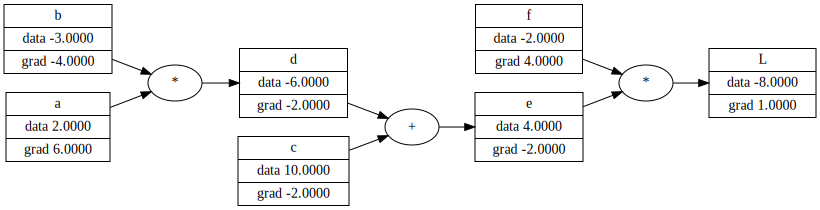

In [15]:
draw_dot(L)

Now, manually backpropogating is a bit cumbersome. 

So, we can implement a function to do these derivative calculations and do the backpropogation for us, for each operation we perform.

This function is the `_backward` function, this function will be called when we are going backwards through the graph and help us basically 
apply the chain rule.

For each operation, the `_backward` function will leave a "fingerprint" of the operation in the resulting output.

We can then call this "fingerprint" function on the output of the operation to see the gradients of the inputs with respect to the output.

In [16]:
# defining the skeleton of the autograd engine
class Value:
    def __init__(self, data, children=(), op="", label='') -> None:
        self.data = data
        self.grad = 0
        self._backward = lambda:None
        self._prev = set(children)
        self._op = op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, children=(self, other), op='+')

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward         # we are not calling _backward, they return None, we are storing the function itself.

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, children=(self, other), op='*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward =_backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, children=(self, ), op='tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        
        return out


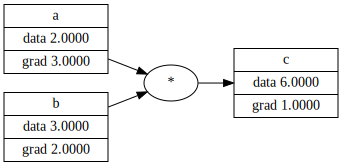

In [17]:
a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = a*b; c.label = 'c'
c.grad = 1.0
c._backward()
draw_dot(c)

With this help, we can try to backpropogate on a slightly different set of operations: the mathematical model of the Neuron.

In [18]:
# simple neuron with two inputs, and thus 2 weights, and a bias
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias value of the neuron
b = Value(6.881373, label='b')
#x1*w1 + x2*w2 + b = n
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# output = tanh(n)
o = n.tanh(); o.label ='o'

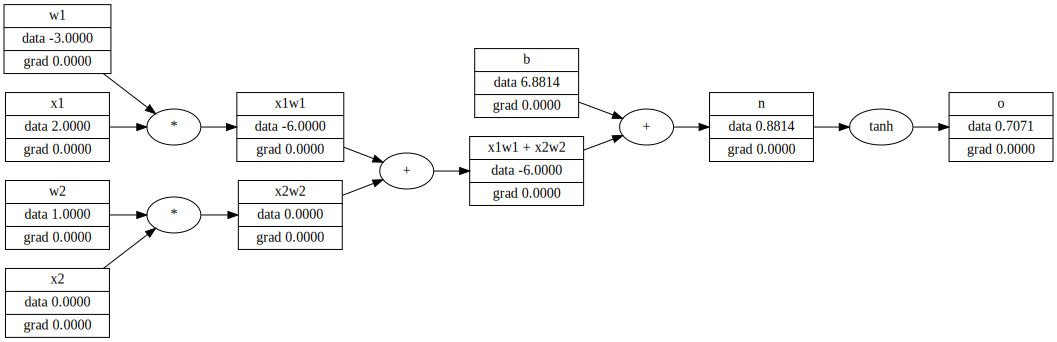

In [19]:
draw_dot(o)

In [20]:
o.grad = 1.0 # since the gradient of o w.r.t o is just 1.
o._backward()
n._backward()

In [21]:
b._backward() # won't return anything since it is not the result of an operation
x1w1x2w2._backward()

In [22]:
x2w2._backward()
x1w1._backward()

Even still, calling _backward() manually is a bit cumbersome as well, although less cumbersome than the manual differentiation.

We can instead, organize the nodes in a particular order, so that the leaf nodes ( inputs that aren't the result of an operation ) are last and the root node is first. 

This is to make sure that when we are calling backward() on a node, we are calling it after running backward() on the nodes that
came after it. 

Then, recursively apply the _backward function from the root node to the leaf nodes. 

We can do this by doing a topological sort, then reversing the result. 
From my understanding, a topological sort makes sure that every node is ordered such that for every edge between nodes A and B, A comes before B.

In [23]:
# topological sort
topo = []
visited = set()
def topological_sort(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            topological_sort(child)
        topo.append(v)

topological_sort(o)
print("This is the ordering of nodes after the topological sort: ", topo,)
print("\nThis is the reversed output:", list(reversed(topo)))


This is the ordering of nodes after the topological sort:  [Value(data=6.881373), Value(data=2.0), Value(data=-3.0), Value(data=-6.0), Value(data=1.0), Value(data=0.0), Value(data=0.0), Value(data=-6.0), Value(data=0.881373), Value(data=0.7071064876766542)]

This is the reversed output: [Value(data=0.7071064876766542), Value(data=0.881373), Value(data=-6.0), Value(data=0.0), Value(data=0.0), Value(data=1.0), Value(data=-6.0), Value(data=-3.0), Value(data=2.0), Value(data=6.881373)]


The next thing would be to call the \_backward() function for each node in the reversed topological sort.

Let's see this in action. (Scroll up, reinitialize and draw the graph)

In [24]:
o.grad = 1.0
for node in reversed(topo):
    node._backward()

It works.

Next, it's time to coalesce this into a single function that can be called from a Value object.

This function will defined as the official `backward()` function, not `_backward()`.

In [25]:
# defining the skeleton of the autograd engine
class Value:
    def __init__(self, data, children=(), op="", label='') -> None:
        self.data = data
        self.grad = 0
        self._backward = lambda:None
        self._prev = set(children)
        self._op = op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, children=(self, other), op='+')

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward         # we are not calling _backward, they return None, we are storing the function itself.

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, children=(self, other), op='*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward =_backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, children=(self, ), op='tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        # topological sort
        topo = []
        visited = set()
        def topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topological_sort(child)
                topo.append(v)
        topological_sort(self)

        # set the gradient of self w.r.t self as 1
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


Now we can just call the backward() function from the root node and watch the gradients backpropogate w.r.t
the root node.

Scroll up, reinitialize, call backward(), and draw.

In [26]:
o.backward()

AttributeError: 'Value' object has no attribute 'backward'

Another slight fix needs to be made:

When the gradients are being computed, in the case of multiple nodes taking input from a single node, the global gradient
w.r.t the single node gets constantly updated instead of being added.

Here's a simple example:

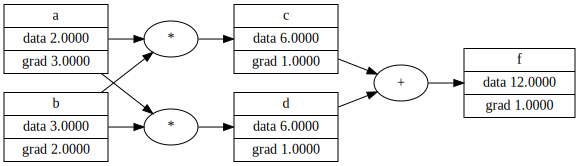

In [27]:
a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = a * b; c.label = 'c'
d = a * b; d.label = 'd'
f = c + d; f.label = 'f'
f.backward()
draw_dot(f)

The global gradient w.r. to a should be 6, while the gradient w.r. to b should be 4.

This error exists because the _backward function that is called for each operation done overwrites the gradient value.

So, when we go backwards to a from c, the gradient is 3, and when we go backwards to a from d the gradient gets overwritten
to 3 again, but these gradients should add/accumulate.

In order to fix this, we replace `self.grad =` and `other.grad =` with `self.grad +=` and `other.grad+=`

This should make sense for those somewhat familiar with the multivariable chain rule from calculus.

If $z = f(u, v)$ and $u = g(x, y), v = h(x, y)$:

$
\frac{\partial z}{\partial x} = \frac{\partial z}{\partial u} \frac{\partial u}{\partial x} + \frac{\partial z}{\partial v} \frac{\partial v}{\partial x}
$

In [28]:
# defining the skeleton of the autograd engine
class Value:
    def __init__(self, data, children=(), op="", label='') -> None:
        self.data = data
        self.grad = 0
        self._backward = lambda:None
        self._prev = set(children)
        self._op = op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, children=(self, other), op='+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward         # we are not calling _backward, they return None, we are storing the function itself.

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, children=(self, other), op='*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward =_backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, children=(self, ), op='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        # topological sort
        topo = []
        visited = set()
        def topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topological_sort(child)
                topo.append(v)
        topological_sort(self)

        # set the gradient of self w.r.t self as 1
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


Now, if we go back to the error example, it should work, since the gradients can accumulate.

There are still minor improvements that can be made to our operations functions.

We can allow for our `Value` objects to be added / multiplied with non-`Value` objects.

In [29]:
# defining the skeleton of the autograd engine
class Value:
    def __init__(self, data, children=(), op="", label='') -> None:
        self.data = data
        self.grad = 0
        self._backward = lambda:None
        self._prev = set(children)
        self._op = op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # if other is not Value object, wrap it to be a Value object.
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, children=(self, other), op='+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward         # we are not calling _backward, they return None, we are storing the function itself.

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, children=(self, other), op='*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward =_backward

        return out
    
    def __rmul__(self, other): # will be called when something tries to multipy with a Value object
        return self * other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, children=(self, ), op='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        # topological sort
        topo = []
        visited = set()
        def topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topological_sort(child)
                topo.append(v)
        topological_sort(self)

        # set the gradient of self w.r.t self as 1
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



Next, we should add more fundamental operations like: $e^{x}$ and divison to be able to backpropogate through more 
complex functions.

In [30]:
# defining the skeleton of the autograd engine
class Value:
    def __init__(self, data, children=(), op="", label='') -> None:
        self.data = data
        self.grad = 0
        self._backward = lambda:None
        self._prev = set(children)
        self._op = op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # if other is not Value object, wrap it to be a Value object.
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, children=(self, other), op='+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward         # we are not calling _backward, they return None, we are storing the function itself.

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, children=(self, other), op='*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward =_backward

        return out
    
    def __rmul__(self, other): # will be called when something tries to multipy with a Value object
        return self * other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, children=(self, ), op='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), children=(self, ), op='exp')

        def _backward():
            # the local gradient of e^x is just e^x
            local_grad = out.data
            # remember, self.grad is the global gradient w.r. to self,
            # local_grad is the gradient w.r.t to the operation performed
            # out.grad is the global gradient w.r. to the result node of the operation. 
            self.grad = local_grad * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        # topological sort
        topo = []
        visited = set()
        def topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topological_sort(child)
                topo.append(v)
        topological_sort(self)

        # set the gradient of self w.r.t self as 1
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [31]:
a = Value(2.0)
# e^2
a.exp()

Value(data=7.38905609893065)

Division can be represented as $\frac{a}{b}$, but it can also be represented by $a\cdot \frac{1}{b}$

Building upon that, division can be thought of as a special case of the power function, so the expression
$a \cdot b^{-1}$ is the same as the expression above.

With that in mind, let's implement the `__truediv__` and  `__pow__` function.

In [113]:
# defining the skeleton of the autograd engine
class Value:
    def __init__(self, data, children=(), op="", label='') -> None:
        self.data = data
        self.grad = 0
        self._backward = lambda:None
        self._prev = set(children)
        self._op = op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # if other is not Value object, wrap it to be a Value object.
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, children=(self, other), op='+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward         # we are not calling _backward, they return None, we are storing the function itself.

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, children=(self, other), op='*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward =_backward

        return out
    
    def __rmul__(self, other): # will be called when something tries to multipy with a Value object
        return self * other
    
    def __pow__(self, other): # pow function that only allows raising to a constant. x^k
        assert(isinstance(other, (int, float)))
        out = Value(self.data ** other, children=(self, ), op=f'**{other}')

        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
        
    def __truediv__(self, other):
        return self * other ** -1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, children=(self, ), op='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), children=(self, ), op='exp')

        def _backward():
            # the local gradient of e^x is just e^x
            local_grad = out.data
            # remember, self.grad is the global gradient w.r. to self,
            # local_grad is the gradient w.r.t to the operation performed
            # out.grad is the global gradient w.r. to the result node of the operation. 
            self.grad = local_grad * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        # topological sort
        topo = []
        visited = set()
        def topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topological_sort(child)
                topo.append(v)
        topological_sort(self)

        # set the gradient of self w.r.t self as 1
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rtruediv__(self, other): # other / self
        return other * self**-1    

In [38]:
a = Value(2.0, label='a')
b = Value(4.0, label='b')
a - b

Value(data=-2.0)

With these newly implemented operations, we can break up the tanh function we called earlier into smaller, simpler operations
and still get the same result.

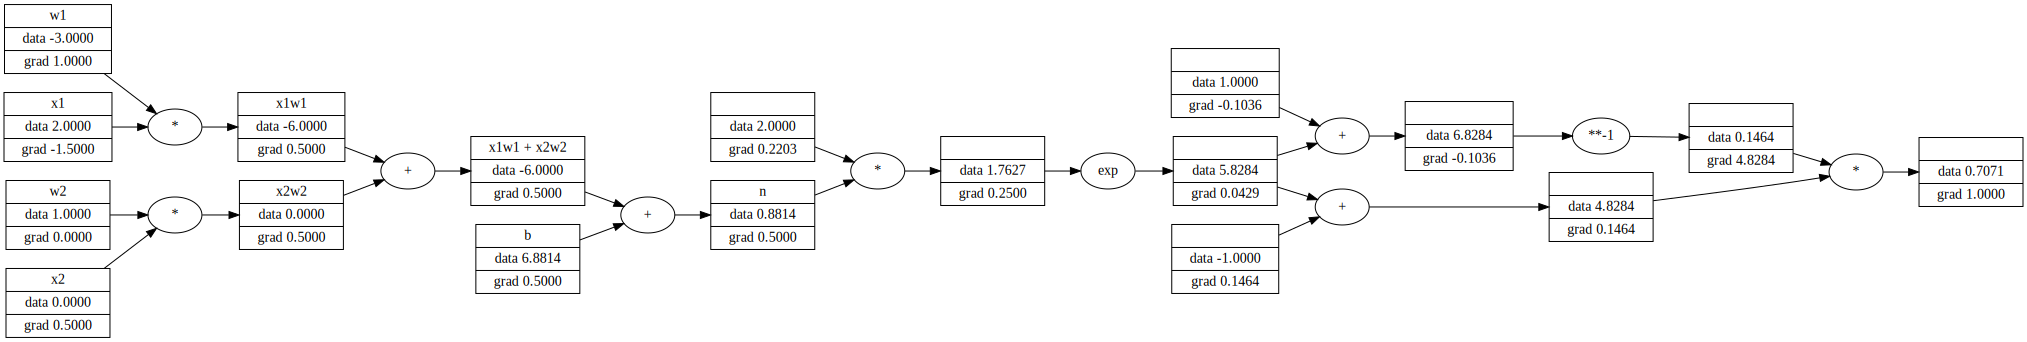

In [40]:
# simple neuron with two inputs, and thus 2 weights, and a bias
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias value of the neuron
b = Value(6.881373, label='b')
#x1*w1 + x2*w2 + b = n
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
#-------
e = (2*n).exp()
o = (e - 1) / (e + 1)
#-------
o.backward()
draw_dot(o)

Now, we can break down any "composite operation" into smaller constituents, that we are able to do a backward pass through.

Let's try and see how a production-level deep learning library does the same thing.

In [41]:
import torch

Pytorch works with tensors, which are n-dimensional matrices/arrays, instead of our little library that works with scalar values.

This enables for highly efficient parallelized computation done on arrays of values, instead of just single, scalar values.

In [44]:
# Tensors are n-dimensional arrays
torch.Tensor([[1, 2, 3], [4, 5, 6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])


In [46]:
# This tensor is a 2 x 3 array; 2 rows x 3 columns
torch.Tensor([[1, 2, 3], [4, 5, 6]]).shape

torch.Size([2, 3])

In [55]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.88137]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
o.backward()

print(x1.grad.item())
print(w1.grad.item())
print(x2.grad.item())
print(w2.grad.item())

-1.500007465833125
1.0000049772220834
0.5000024886110417
0.0


Okay, now that we've seen a little as to how production-level libraries do it, let's go back to our library and try to build
some models off of it.

Let's define a neuron:

![](https://cs231n.github.io/assets/nn1/neuron_model.jpeg)

In [89]:
import random
class Neuron:
    def __init__(self, n_in):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_in)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        activation = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out

n = Neuron(2)
x = [1.0, 2.0]
n(x)

Value(data=0.4850844939748809)

Next, to build a neural net (or Multi-Layer Perceptron), we need layers of these neurons.

![](https://cs231n.github.io/assets/nn1/neural_net2.jpeg)

In [108]:
class Layer:
    def __init__(self, n_in, n_out):
        # create n_out nuerons that take the same n_in inputs
        self.neurons = [Neuron(n_in) for _ in range(n_out)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

l = Layer(2, 3)
x = [2.0, 3.0]
l(x)

[Value(data=-0.02172675083591104),
 Value(data=-0.1689399786893467),
 Value(data=0.6050586243667776)]

In [115]:
class MLP:
    def __init__(self, n_in, n_outs):
        # creates a list of the size of all layers, including the input layer
        size = [n_in] + n_outs
        self.layers = [Layer(size[i], size[i + 1]) for i in range(len(n_outs))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

m = MLP(3, [4, 4, 1])
x = [2.0, 3.0, -1.0]
m(x)

Value(data=0.9244704091294622)

Now, let's try to test our MLP on a small dataset.

In [137]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

[Value(data=-0.34498944668650444),
 Value(data=0.6673238510036007),
 Value(data=0.928589334668487),
 Value(data=0.12883681840735195)]

We can use a single value to measure how wrong our neural network is, called a **loss**

In [ ]:
y_pred = [m(x) for x in xs]

In [124]:
# calculate the error for each prediction in relation to the ground truth label
errors = [(y_out - y_gt) for y_out, y_gt in zip(ys, y_pred)]
errors

[Value(data=0.07552959087053779),
 Value(data=-1.9036249092975241),
 Value(data=-1.2275275973008137),
 Value(data=0.2542185212244833)]

In [118]:
# sum of squared errors, to give us a single measure
loss = sum((y_out - y_gt) ** 2 for y_out, y_gt in zip(ys, y_pred))
loss

Value(data=5.20094357306375)

Let's try to backpropogate after calculating our loss and see how each weight contributes to the overall loss of the MLP.

It's crazy to see how large an expression it becomes for just a small neural net.

In [ ]:
loss.backward()
draw_dot(loss)

It's important to be able to see what are parameters and be able to access their gradients all in one place, so let's create a function to get all the parameters from a particular neuron, layer, neural net, etc.

In [127]:
class Neuron:
    def __init__(self, n_in):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_in)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        activation = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, n_in, n_out):
        # create n_out nuerons that take the same n_in inputs
        self.neurons = [Neuron(n_in) for _ in range(n_out)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [parameter for neuron in self.neurons for parameter in neuron.parameters()]

class MLP:
    def __init__(self, n_in, n_outs):
        # creates a list of the size of all layers, including the input layer
        size = [n_in] + n_outs
        self.layers = [Layer(size[i], size[i + 1]) for i in range(len(n_outs))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [parameter for layer in self.layers for parameter in layer.parameters()]

If we take a look and see, our small neural net has 41 parameters in total.

Now, going back a little bit, in reference to our loss, what can we do to our parameters such that we can make the loss smaller the next time around?

In [187]:
m = MLP(3, [4, 4, 1])
print(m.parameters())
len(m.parameters())

[Value(data=-0.46082505061507106), Value(data=-0.6651617438079214), Value(data=-0.8431281210412138), Value(data=0.5886204834435127), Value(data=-0.7590016941466968), Value(data=-0.6486270059325965), Value(data=-0.4999201954861119), Value(data=-0.4101828576452131), Value(data=-0.25363059398781296), Value(data=0.05224295598520179), Value(data=0.6887269909951117), Value(data=0.9834167242177876), Value(data=0.9215868473147597), Value(data=0.7256028589482784), Value(data=0.1835025197203206), Value(data=-0.26080070468859273), Value(data=-0.023780554930281195), Value(data=0.7702066871608144), Value(data=-0.7653723643851817), Value(data=-0.16233617184987303), Value(data=-0.12850494047545835), Value(data=0.3078345574420722), Value(data=0.8717179041480332), Value(data=0.525416905479033), Value(data=0.05668974233954516), Value(data=0.6619390830464063), Value(data=-0.9856886237890838), Value(data=0.556133778358282), Value(data=-0.11289977303063448), Value(data=0.8749557944825193), Value(data=0.473

41

In [227]:
y_pred = [m(x) for x in xs]
loss = sum((y_out - y_gt) ** 2 for y_out, y_gt in zip(ys, y_pred))
loss

Value(data=0.04966003306732808)

We can use our knowledge of a parameter's gradient w.r. to the loss to be able to nudge the parameter's value in such a way that we decrease the overall loss.

The gradient is a vector that points in the direction of maximum increase of the loss, so if a parameter has a positive gradient, then the corresponding nudge should be in the other direction and vice versa. 

In [226]:
# manual gradient descent
step_size = 0.01
loss.backward()
for p in m.parameters():
    p.data += step_size * -(p.grad)

If we keep nudging, calculating the loss, backpropogate to calculate the gradients, and repeat the process over and over again, 
the loss would continue to get smaller and smaller which is good. (but up to a certain point)

Be careful with the `step_size` or how large your nudges are going to be, because if you take too big of a step, you may actually overstep _away_ from the optimal point.

Remember, we don't actually know exactly about the loss function. 

The loss function has all kinds of structure and we only know about the very local dependence of all these parameters on the loss, but if you step too far, then it can step into a part of the loss function that is completely different, and destabilize training, and maybe even cause your loss to blow up even.

In [228]:
# practically perfect
print(loss)
print(y_pred)

Value(data=0.04966003306732808)
[Value(data=0.9646803611864846), Value(data=-0.7828246470881502), Value(data=-0.9993171711536978), Value(data=0.9646877356462223)]


Now, we've basically trained a neural net! from scratch!

We should still condense these important steps into a single for loop:

In [232]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

m = MLP(3, [4, 4, 1])

In [234]:
step_size = 0.01
for epoch in range(20):
    # forward pass
    y_pred = [m(x) for x in xs]
    loss = sum((y_out - y_gt) ** 2 for y_out, y_gt in zip(y_pred, ys))

    # backward pass
    loss.backward()

    # update
    for p in m.parameters():
        p.data += step_size * -(p.grad)
    
    print('epoch:', epoch, 'loss:', loss.data)

epoch: 0 loss: 0.006186628872133896
epoch: 1 loss: 0.010184040966859091
epoch: 2 loss: 0.020358688686939623
epoch: 3 loss: 0.05131003183359485
epoch: 4 loss: 0.1897602028379169
epoch: 5 loss: 0.11681276371545668
epoch: 6 loss: 0.025012067593537548
epoch: 7 loss: 0.007990983181506086
epoch: 8 loss: 0.0031750245512438113
epoch: 9 loss: 0.0012999017212911826
epoch: 10 loss: 0.0005260548234815089
epoch: 11 loss: 0.00021157719319642865
epoch: 12 loss: 8.451984624715359e-05
epoch: 13 loss: 3.416036443898478e-05
epoch: 14 loss: 1.5147177959408112e-05
epoch: 15 loss: 8.649589518740035e-06
epoch: 16 loss: 7.139546385529324e-06
epoch: 17 loss: 7.87387101889972e-06
epoch: 18 loss: 1.0096815446075072e-05
epoch: 19 loss: 1.3968326529754001e-05


What are we missing here? 

The gradient descent loop looks great, but there is one mistake that can cause a terrible bug.

The answer is that the gradient w.r to each paramter needs to be set to zero before backpropogating through the operations.

Why is that?

Well, if we don't zero out the gradients, by the way backpropogation is defined the gradient start at zero in the very beginning and start accumulating as we backpropogate through the network.

If we don't refresh the gradients, the gradients from the previous backward pass will still be present and the current backward pass will add onto the previous backward pass gradient which is not what we want.

We don't want the gradient from the previous pass to contribute to the current one, since we want to see how good of a job the current parameter values affect the loss and nudge them by looking at the current gradient w.r.t to these values, not the current gradient + previous gradients.

So, this is how it should actually look like.

In [235]:
step_size = 0.01
for epoch in range(20):
    # forward pass
    y_pred = [m(x) for x in xs]
    loss = sum((y_out - y_gt) ** 2 for y_out, y_gt in zip(y_pred, ys))

    # backward pass
    for p in m.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in m.parameters():
        p.data += step_size * -(p.grad)
    
    print('epoch:', epoch, 'loss:', loss.data)

epoch: 0 loss: 2.029169531291033e-05
epoch: 1 loss: 2.0281228922869235e-05
epoch: 2 loss: 2.0270773332820213e-05
epoch: 3 loss: 2.026032852608451e-05
epoch: 4 loss: 2.0249894486017992e-05
epoch: 5 loss: 2.0239471196008058e-05
epoch: 6 loss: 2.0229058639478516e-05
epoch: 7 loss: 2.021865679988869e-05
epoch: 8 loss: 2.0208265660726223e-05
epoch: 9 loss: 2.0197885205520108e-05
epoch: 10 loss: 2.0187515417828695e-05
epoch: 11 loss: 2.0177156281241522e-05
epoch: 12 loss: 2.0166807779388334e-05
epoch: 13 loss: 2.015646989592713e-05
epoch: 14 loss: 2.0146142614551953e-05
epoch: 15 loss: 2.0135825918987908e-05
epoch: 16 loss: 2.0125519792998213e-05
epoch: 17 loss: 2.011522422036902e-05
epoch: 18 loss: 2.0104939184935466e-05
epoch: 19 loss: 2.0094664670547572e-05


Now, things should update much more smoothly. 

If you had a more complex problem, then this bug would of made the model not optimize very well.

We were only able to get away with it since it's a smaller problem.